## TODO:
- change scraping because it doesnt get the actor's role it's playing.

## Scraping data

In [288]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import re
import pandas as pd

In [460]:
base_url_pages = 'https://www.imdb.com/search/title/?genres={}&view=simple&start={}&ref_=adv_nxt'

page_nrs = ['151', '201', '251'] #'1', '50', '151', '201', '251'
genres = ['adventure', 'comedy', 'family', 
          'romance', 'sci-fi', 'thriller', 
            'mystery', 'western',  'horror',
            'crime', 'war', 'musical']

In [461]:
#scraping movies per category
def scrape_movies(urls, pages, genres):
    movie_dict = {}
    
    for genre in genres:
        movie_dict.update({genre : {}})
        for page_nr in pages:
            url = urls.format(genre, page_nr)
            response = requests.get(url)

            soup = BeautifulSoup(response.text, 'html.parser')

            for line in soup.findAll("span", {"class": "lister-item-header"}):
                link = re.findall('(?<=a href=").*?(?=">)', str(line))[0]
                name = re.findall("(?<=>).*?(?=</a>)", str(line))[0]
                name = name.replace('&amp;', '&')
                movie_dict[genre].update({name: {'url': link}})
    return movie_dict

dict_test = scrape_movies(base_url_pages, page_nrs, genres)
            
# scraping cast per movie
def scrape_cast_movie(movie):
    url = 'https://www.imdb.com/title/{}'.format(movie)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
#     summary = soup.find("div", class_="summary_text").contents[0].strip()
    actors_in_movie = []
    for i in soup.findAll("table", class_ = "cast_list"):
        actors = set(re.findall('(?<=a href="/name/).*?(?=/")', str(i)))
        for actor in actors:
            role = re.findall('(?<={}/">).*?(?=\n</a>)'.format(actor), str(i))
            actors_in_movie.append({actor:role})
    return actors_in_movie #, summary
            
        

In [465]:
def get_meta_data(movie_id):
    r = requests.get('http://www.omdbapi.com/?i={}&apikey=8147210c'.format(movie_id))
    return r.json() if r.status_code == 200 else {'api_error':' {}'.format(r.status_code)}

In [466]:
import wikipedia as wiki
wiki.set_lang("en")  

def get_wiki_plot(movie_id):
    data = get_meta_data(movie_id)
    try:
        search = data['Title'] + ' ' + data['Year'] + ' (film)'
        search_result = wiki.search(search, 1)[0]
    except:
        return ('NoSearch', data)
    found = False

    url = 'https://en.wikipedia.org/wiki/{}'.format('_'.join(search_result.split(' ')))
    response = requests.get(url)
    txt = BeautifulSoup(response.text, 'html.parser').text
    txt_list = txt.split('\n')
    plot_names = ['Premise', 'Plot', 'Plot[edit]', 'Premise[edit]']
    indexes = [txt_list.index(i) for i in plot_names if i in txt.split('\n')]
    if len(indexes) > 0:
        index_end = indexes[0] + txt_list[indexes[0]:].index('')
        text_movie = txt_list[indexes[0]+1: index_end]
        found = True

    return (text_movie, data) if found else (['NoText'], data)
 

In [467]:
#gives a list of all movies in the dictionary
def get_movies_df(dict_movies):
    movies = []
    movie_info = []
    for item in dict_movies:
        print(item)
        for movie in dict_movies[item]:
            if movie not in movies:
                movie_id = dict_movies[item][movie]['url'][7:-1]
                movies.append(movie)
                #get all data 
                wiki_txt, data = get_wiki_plot(movie_id)
                cast = scrape_cast_movie(movie_id)
                try:
                    print(data['Title'])
                    movie_info.append([movie, cast, wiki_txt, data['Title'], data])
                except:
                    pass
                
    df = pd.DataFrame(data=movie_info, columns= ['movie_id', 'cast','summary_wiki', 'movie_name', 'info_json'])
    return df
# print(get_all_movies(dict_test))

In [468]:
#create a movie_df with columns = ['movie_id', 'summary_wiki', 'summary_imdb', 'movie_name', 'info_json']
#list of all unique movie_ids
all_movies = get_movies_df(dict_test)

#create an actor_df with columns = ['actor_id', 'movie_id', 'role_name']

adventure
The Goonies
Fantastic Beasts: The Crimes of Grindelwald
Moana
A Shaun the Sheep Movie: Farmageddon
Star Wars: Episode VII - The Force Awakens
Transformers: The Last Knight
X-Men: Apocalypse
Quantum of Solace
Deadpool
The Princess Bride
Dune
Jurassic World: Fallen Kingdom
Captain America: The First Avenger
Hook
Harry Potter and the Goblet of Fire
Annihilation
Spirited Away
Jumanji
Jurassic World 3
Dragon Quest: Your Story
Maleficent
Dora and the Lost City of Gold
The Avengers
Spies in Disguise
Dances with Wolves
Zootopia
Almost Famous
Pirates of the Caribbean: The Curse of the Black Pearl
Batman v Superman: Dawn of Justice
Guardians of the Galaxy Vol. 2
Descendants 3
The Lord of the Rings: The Two Towers
Free Guy
Untitled Indiana Jones Project
Castlevania
Zombieland
Amazing Stories
Peter Rabbit
The Falcon and the Winter Soldier
Solo: A Star Wars Story
Batman
The Iron Mask
The Hobbit: An Unexpected Journey
Chaos Walking
Indiana Jones and the Temple of Doom
Trolls World Tour
Per

He's Just Not That Into You
Moulin Rouge!
Saved by the Bell
Ordinary Love
Official Secrets
The Concubine
Ghost
As Good as It Gets
Victorious
Bill & Ted's Excellent Adventure
Dawson's Creek
Vertigo
Higher Learning
Edward Scissorhands
Midnight in Paris
The Bad Batch
Olympic Dreams
Radioactive
Versailles
Roswell, New Mexico
Secretary
The Nanny
The Aftermath
The Girl Next Door
The Secret: Dare to Dream
The Terminal
The L Word
Footloose
The Danish Girl
Pride and Prejudice and Zombies
Inherent Vice
Anna Karenina
Amélie
Cast Away
She's Out of My League
Big Fish
The Bachelor
To All the Boys I've Loved Before 3
Dallas
Pearl Harbor
Hercules
The Dreamers
Easy A
The Waltons
Snow White and the Huntsman
Just Friends
When Harry Met Sally...
Jerry Maguire
She's All That
EastEnders
King Kong
A Ghost Story
Say Anything...
The Big Sick
Breakfast at Tiffany's
Sixteen Candles
The Phantom of the Opera
The Princess and the Frog
Move Over, Darling
Revolutionary Road
Malena
Blue Valentine
Lolita
Bridget Jones'

Pitch Black
The Strain
Sleepy Hollow
Blade: Trinity
Evil Dead
The Ring
Annabelle: Creation
Friday the 13th
The Ritual
The Autopsy of Jane Doe
The Following
It Follows
It
The Evil Dead
Blade II
Jennifer's Body
The Conjuring 2
Species
Resident Evil
The Silence
The Uninvited
The Descent
The Human Centipede (First Sequence)
The Craft
Diablero
Penny Dreadful: City of Angels
1922
Death Stranding
Cannibal Holocaust
The Texas Chain Saw Massacre
Extra Ordinary
The Dark Tower
Insidious
Bliss
Torchwood
It Comes At Night
Velvet Buzzsaw
Black Spot
Ash vs Evil Dead
Verónica
Final Destination
The Faculty
Candyman
47 Meters Down
Hemlock Grove
Hellraiser
8: A South African Horror Story
Hostel: Part II
Wounds
Apostle
Antichrist
Happy Death Day
The Hills Have Eyes
The Jack in the Box
28 Weeks Later
Cupid
The Wind
Dawn of the Dead
The Mist
Underworld: Blood Wars
Green Room
Tumbbad
Scream 4
Silent Hill
Harpoon
Hush
Jigsaw
Manhunter
Sweetheart
Scream: The TV Series
Little Monsters
Deliver Us from Evil
They 

## Text cleaning

In [471]:
def check(list_wiki):
    if len(list_wiki) == 1:
        return False if list_wiki[0] == 'NoText' else True
    else:
        return True

data = all_movies[all_movies['summary_wiki'].apply(lambda x: check(x))]
data['summary_wiki'] = data['summary_wiki'].apply(lambda x: ' '.join([i for i in x]))

/Users/sebastiaanvergunst/anaconda3/envs/text_mining/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Doc2Vec

In [473]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [565]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data['summary_no_names'])]

### Train doc2vec model

In [566]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =0) #changing dm to dm=0 will make it use BoW approach)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    model.alpha -= 0.0002
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

/Users/sebastiaanvergunst/anaconda3/envs/text_mining/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/Users/sebastiaanvergunst/anaconda3/envs/text_mining/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

### Test model

In [567]:
model= Doc2Vec.load("d2v.model")

#using deadpool(1) as test case
test_data = word_tokenize("""Wade Wilson is a dishonorably discharged special forces operative working as a mercenary when he meets Vanessa, a prostitute. They become romantically involved, and a year later she accepts his marriage proposal. Wilson is diagnosed with terminal cancer, and leaves Vanessa without warning so she will not have to watch him die.

A mysterious recruiter approaches Wilson, offering an experimental cure for his cancer. He is taken to Ajax and Angel Dust, who inject him with a serum designed to awaken latent mutant genes. They subject Wilson to days of torture to induce stress and trigger any mutation he may have, without success. When Wilson discovers Ajax's real name is Francis and mocks him for it, Ajax leaves Wilson in a hyperbaric chamber that periodically takes him to the verge of asphyxiation over a weekend. This finally activates a superhuman healing ability that cures the cancer but leaves Wilson severely disfigured with burn-like scars over his entire body. He escapes from the chamber and attacks Ajax but relents when told that his disfigurement can be cured. Ajax subdues Wilson and leaves him for dead in the now-burning laboratory.

Wilson survives and seeks out Vanessa. He does not reveal to her he is alive fearing her reaction to his new appearance. After consulting with his best friend Weasel, Wilson decides to hunt down Ajax for the cure. He becomes a masked vigilante, adopting the name "Deadpool" (from Weasel picking him in a dead pool), and moves into the home of an elderly blind woman named Al. He questions and murders many of Ajax's men until one, the recruiter, reveals his whereabouts. Deadpool intercepts Ajax and a convoy of armed men on an expressway. He kills everyone but Ajax, and demands the cure from him but the X-Man Colossus and his trainee Negasonic Teenage Warhead interrupt him. Colossus wants Deadpool to mend his ways and join the X-Men. Taking advantage of this distraction, Ajax escapes. He goes to Weasel's bar where he learns of Vanessa.

Ajax kidnaps Vanessa and takes her to a decommissioned helicarrier in a scrapyard. Deadpool convinces Colossus and Negasonic to help him. They battle Angel Dust and several soldiers while Deadpool fights his way to Ajax. During the battle, Negasonic accidentally destroys the equipment stabilizing the helicarrier. Deadpool protects Vanessa from the collapsing ship, while Colossus carries Negasonic and Angel Dust to safety. Ajax attacks Deadpool again but is overpowered. He reveals there is no cure after all and, despite Colossus's pleading, Deadpool kills him. He promises to try to be more heroic moving forward. Though Vanessa is angry with Wilson for leaving her, she reconciles with him.""".lower())


# find all similair movie plots
similar_doc = model.docvecs.most_similar(positive=[model.infer_vector(test_data)],topn=10)
for doc, perc in similar_doc:
    print('movie:',data.iloc[int(doc)]['movie_id'], '   Similarity:', perc)
    print('summary: ' , data.iloc[int(doc)]['info_json']['Plot'], '\n')

movie: Deadpool    Similarity: 0.9416628479957581
summary:  A wisecracking mercenary gets experimented on and becomes immortal but ugly, and sets out to track down the man who ruined his looks. 

movie: X-Men: First Class    Similarity: 0.7885173559188843
summary:  In the 1960s, superpowered humans Charles Xavier and Erik Lensherr work together to find others like them, but Erik's vengeful pursuit of an ambitious mutant who ruined his life causes a schism to divide them. 

movie: Spider-Man    Similarity: 0.772121787071228
summary:  When bitten by a genetically modified spider, a nerdy, shy, and awkward high school student gains spider-like abilities that he eventually must use to fight evil as a superhero after tragedy befalls his family. 

movie: The Rhythm Section    Similarity: 0.7634783983230591
summary:  A woman seeks revenge against those who orchestrated a plane crash that killed her family. 

movie: Deadpool 2    Similarity: 0.7617839574813843
summary:  Foul-mouthed mutant mer

## LDA (Latent Diriclet Allocation)

### Prepare data for LDA
- see if removing names from the text by using NER will improve model performance.

In [560]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
import spacy


nlp = spacy.load('en_core_web_sm')
stop_words = stopwords.words("english")

#filter out names through nerc
def remove_names(text):
    document = nlp(text)
    ents = [e.text for e in document.ents if e.label_ != 'PERSON']
    return " ".join([item.text for item in document if item.text not in ents])

data['summary_no_names'] = data['summary_wiki'].apply(lambda x: remove_names(x))

def tokenize(content):
    letters_only = re.sub("[^a-zA-Z]",
                      " ",         
                      content )
    lower_case = letters_only.lower()
    tokens = word_tokenize(lower_case)
    words = [w for w in tokens if not w in stop_words]
    stems = [stemmer.lemmatize(word) for word in words]
    return(stems)

#create dictionary and incorporating 1 to n-gram  -> change to tf-idf
stemmer = WordNetLemmatizer()
vectorizer = CountVectorizer(ngram_range = (1,2),
                             lowercase = True,
                             tokenizer=tokenize,
                             preprocessor = None,
                             max_features=5000)

tfidf_vect = TfidfTransformer(use_idf=True)#, #ngram_range=(1, 2),
#                                    lowercase=True, tokenizer=tokenize,
#                                    preprocessor=None, max_features=10000)


#bag of words
bow = vectorizer.fit_transform(data['summary_no_names'])

# vectorizer.vocabulary_
tfidf = tfidf_vect.fit_transform(bow)

/Users/sebastiaanvergunst/anaconda3/envs/text_mining/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### train model
Still need to perform parameter tuning (aka choose the right amount of topics)
- Model works better with bow than tf-idf (distribution of clusters is better). When using tf-idf, we get a very skewed distribution.



In [582]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

nb_topics = 20
lda = LatentDirichletAllocation(n_components=nb_topics, max_iter=20,
                                learning_method='batch')
document_topics = lda.fit_transform(bow)
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vectorizer.get_feature_names())

def print_topics(topics, feature_names, sorting, topics_per_chunk=6,
                 n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        these_topics = topics[i: i + topics_per_chunk]
        len_this_chunk = len(these_topics)
        words = []
        for i in range(n_words):
            try:
                words.append(feature_names[sorting[these_topics, i]])
            except:
                pass

    #setting up word dictionary for comparison
    word_dict = {}
    for i in topics:
        word_dict.update({i : [word[i] for word in words]})
    
    return word_dict

lda_topics = print_topics(topics=range(nb_topics), feature_names=feature_names, sorting=sorting, topics_per_chunk=nb_topics, n_words=15)

for i in range(nb_topics):
    print(i,': ' ,lda_topics[i], '\n')

0 :  ['king', 'return', 'love', 'find', 'castle', 'father', 'fall', 'escape', 'kill', 'witch', 'reveals', 'magic', 'princess', 'death', 'back'] 

1 :  ['return', 'find', 'give', 'father', 'mother', 'tell', 'home', 'love', 'new', 'daughter', 'back', 'boy', 'parent', 'take', 'help'] 

2 :  ['house', 'find', 'home', 'woman', 'tell', 'child', 'room', 'later', 'see', 'body', 'death', 'night', 'next', 'man', 'wife'] 

3 :  ['ship', 'crew', 'captain', 'island', 'alien', 'rescue', 'mission', 'pilot', 'attack', 'boat', 'air', 'plane', 'station', 'find', 'fire'] 

4 :  ['kill', 'escape', 'group', 'attempt', 'find', 'reveals', 'team', 'help', 'attack', 'take', 'power', 'zombie', 'fight', 'planet', 'creature'] 

5 :  ['soldier', 'war', 'army', 'force', 'men', 'attack', 'officer', 'order', 'general', 'take', 'battle', 'killed', 'wounded', 'colonel', 'group'] 

6 :  ['town', 'horse', 'mr', 'man', 'take', 'men', 'brother', 'back', 'father', 'family', 'ride', 'return', 'kill', 'get', 'go'] 

7 :  ['fa

In [580]:
data['clusters'] = np.argmax(document_topics, axis=1)

/Users/sebastiaanvergunst/anaconda3/envs/text_mining/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


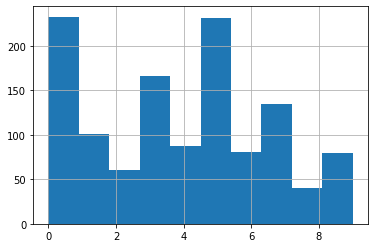

In [581]:
data['clusters'].hist()

## Entity Recognition
https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da

In [427]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [452]:
doc = nlp(data['summary_wiki'][2])

In [453]:
labels = [x.label_ for x in doc.ents]
Counter(labels)

Counter({'PERSON': 5, 'DATE': 3, 'ORG': 3, 'LOC': 2, 'CARDINAL': 2, 'PRODUCT': 1, 'GPE': 1, 'ORDINAL': 1, 'NORP': 1})

In [454]:
items = [x.text for x in doc.ents]
Counter(items).most_common(3)

[('Viking', 2), ('Lindisfarne', 2), ('Scandinavia', 1)]

In [455]:
sentences = [x for x in doc.sents]
print(sentences[20])

IndexError: list index out of range

In [ ]:
data['']

In [456]:
displacy.render(nlp(str(doc)), jupyter=True, style='ent')

In [437]:
dict([(str(x), x.label_) for x in nlp(str(sentences[20])).ents])

{'Helena': 'GPE'}